## Tennis Game Markov Chain

### Part 1: Basic Setup

This short notebook is part of a series demonstrating how to model a tennis game using Python. For now, we are only going to represent the possible scores and points in one tennis, to count up the possible outcomes.

Future notebooks will show how to incorporate propbability modeling directly in Python. We will also see how to model tiebreakers and sets. With those additions, we can model the possible outcomes of an entire tennis match.

We will use the `networkx` package to represent the tennis game as a [graph](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics%29). A graph is a very intuitive framework for visualizing and analyzing [Markov chains](https://en.wikipedia.org/wiki/Markov_chain).

In [1]:
import networkx as nx

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from enum import Enum
from pathlib import Path
from collections import Counter

In [4]:
PARENT_DIR = Path.cwd().parent
IMAGES_DIR = PARENT_DIR / 'images'
IMAGES_DIR.mkdir(exist_ok=True, parents=True)

### Possible Scores in a Tennis Game

Here is a simple Python `class` representing the possible scores in a game of tennis.

The game is over when the server either holds (wins) or is broken (loses).

In [5]:
class GameScore(Enum):
    """Possible scores of a tennis game."""
    LOVE_LOVE = '0-0'
    FIFTEEN_LOVE = '15-0'
    LOVE_FIFTEEN = '0-15'
    THIRTY_LOVE = '30-0'
    FIFTEEN_ALL = '15-15'
    LOVE_THIRTY = '0-30'
    FORTY_LOVE = '40-0'
    THIRTY_FIFTEEN = '30-15'
    FIFTEEN_THIRTY = '15-30'
    LOVE_FORTY = '0-40'
    FORTY_FIFTEEN = '40-15'
    THIRTY_ALL = '30-30'
    FIFTEEN_FORTY = '15-40'
    FORTY_THIRTY = '40-30'
    THIRTY_FORTY = '30-40'
    DEUCE = 'deuce'
    AD_IN = 'ad in'
    AD_OUT = 'ad out'
    HOLD = 'hold'
    BREAK = 'break'
    
    @property
    def as_tuple(self):
        """Score expressed as tuple of (server, returner) points won (hold and break via one deuce)."""
        if self == GameScore.DEUCE:
            return (3, 3)
        elif self == GameScore.AD_IN:
            return (4, 3)
        elif self == GameScore.AD_OUT:
            return (3, 4)
        elif self == GameScore.HOLD:
            return (5, 3)
        elif self == GameScore.BREAK:
            return (3, 5)
        else:
            s, r = self.value.split('-')
            s = ['0', '15', '30', '40'].index(s)
            r = ['0', '15', '30', '40'].index(r)
            return (s, r)

    @property
    def server_points(self):
        """Number of points won by server prior to this point (hold and break via one deuce)."""
        return self.as_tuple[0]
    
    @property
    def returner_points(self):
        """Number of points won by returner prior to this point (hold and break via one deuce)."""
        return self.as_tuple[1]
    
    @property
    def points_played(self):
        """Number of points played prior to this point (hold and break via one deuce)."""
        return sum(self.as_tuple)

### Modeling a Tennis Game

For our simple model of a tennis game, we need to be clear about two basic concepts. First, the score is the current state of the game. Second, a point is the process by which the score changes. Each distinct point has a starting score, and can wind up in two possible ending scores.

In the language of graph theory, this means that the scores can be represented by the [_nodes_](https://en.wikipedia.org/wiki/Vertex_(graph_theory%29) (also called _vertices_) of the graph. The points will be represented by the [_edges_](https://en.wikipedia.org/wiki/Glossary_of_graph_theory_terms#edge) of the graph.

Toward the end of this notebook is a figure visualizing the tennis game graph which should help make all of this clearer.

We will represent a tennis game in a `class` using the `networkx` to handle all the details.

In [6]:
class TennisGame:
    """Markov chain model of a tennis game."""
    def __init__(self, p=0.5):
        self._G = nx.MultiDiGraph()
        self._add_nodes()
        self._add_edges(p)
        self._node_labels = {n: d['label'] for n, d in self._G.nodes(data=True)}
        self._edge_labels = {(n1, n2): d['label'] for n1, n2, d in self._G.edges(data=True)}
        self._pos = nx.get_node_attributes(self._G, 'pos')
    
    @property
    def graph(self):
        return self._G
    
    @property
    def scores(self):
        return self._G.nodes
    
    @property
    def points(self):
        return self._G.edges
    
    def score_sequences(self, start=GameScore.LOVE_LOVE, end=None):
        """All simple paths between a start node and an end node."""
        return (path for path in nx.all_simple_paths(
            self._G,
            source=start,
            target=end,
        ))
    
    def point_sequences(self, start=GameScore.LOVE_LOVE, end=None):
        """All simple paths between a start node and an end node, represented as edges."""
        return (list(nx.utils.pairwise(path)) for path in self.score_sequences(start, end))
    
    def draw(self, ax):
        """Draw graph of the game Markov chain."""
        nx.draw_networkx(
            self._G, pos=self._pos, ax=ax,
            node_size=1800,
            node_color='yellow',
            with_labels=False,
            edgecolors='grey'
        )
        nodes = nx.draw_networkx_labels(
            self._G, pos=self._pos, ax=ax,
            labels=self._node_labels
        )
        edges = nx.draw_networkx_edge_labels(
            self._G , pos=self._pos, ax=ax,
            label_pos=0.33,
            font_size=9,
            edge_labels=self._edge_labels
        )
        return ax

    def _add_nodes(self):
        for score in GameScore:
            self._G.add_node(
                score,
                label=score.value,
                pos=(score.returner_points-score.server_points, score.points_played)
            )

    def _add_edges(self, p):
        won_point_label = 'p'
        lost_point_label = '1-p'

        self._G.add_edge(
            GameScore.LOVE_LOVE,
            GameScore.FIFTEEN_LOVE,
            prob=p,
            label=won_point_label,
        )
        self._G.add_edge(
            GameScore.LOVE_LOVE,
            GameScore.LOVE_FIFTEEN,
            prob=1-p,
            label=lost_point_label,
        )
        self._G.add_edge(
            GameScore.FIFTEEN_LOVE,
            GameScore.THIRTY_LOVE,
            prob=p,
            label=won_point_label,
        )
        self._G.add_edge(
            GameScore.FIFTEEN_LOVE,
            GameScore.FIFTEEN_ALL,
            prob=1-p,
            label=lost_point_label,
        )
        self._G.add_edge(
            GameScore.LOVE_FIFTEEN,
            GameScore.FIFTEEN_ALL,
            prob=p,
            label=won_point_label,
        )
        self._G.add_edge(
            GameScore.LOVE_FIFTEEN,
            GameScore.LOVE_THIRTY,
            prob=1-p,
            label=lost_point_label,
        )
        self._G.add_edge(
            GameScore.THIRTY_LOVE,
            GameScore.FORTY_LOVE,
            prob=p,
            label=won_point_label,
        )
        self._G.add_edge(
            GameScore.THIRTY_LOVE,
            GameScore.THIRTY_FIFTEEN,
            prob=1-p,
            label=lost_point_label,
        )
        self._G.add_edge(
            GameScore.FIFTEEN_ALL,
            GameScore.THIRTY_FIFTEEN,
            prob=p,
            label=won_point_label,
        )
        self._G.add_edge(
            GameScore.FIFTEEN_ALL,
            GameScore.FIFTEEN_THIRTY,
            prob=1-p,
            label=lost_point_label,
        )
        self._G.add_edge(
            GameScore.LOVE_THIRTY,
            GameScore.FIFTEEN_THIRTY,
            prob=p,
            label=won_point_label,
        )
        self._G.add_edge(
            GameScore.LOVE_THIRTY,
            GameScore.LOVE_FORTY,
            prob=1-p,
            label=lost_point_label,
        )
        self._G.add_edge(
            GameScore.FORTY_LOVE,
            GameScore.HOLD,
            prob=p,
            label=won_point_label,
        )
        self._G.add_edge(
            GameScore.FORTY_LOVE,
            GameScore.FORTY_FIFTEEN,
            prob=1-p,
            label=lost_point_label,
        )
        self._G.add_edge(
            GameScore.THIRTY_FIFTEEN,
            GameScore.FORTY_FIFTEEN,
            prob=p,
            label=won_point_label,
        )
        self._G.add_edge(
            GameScore.THIRTY_FIFTEEN,
            GameScore.THIRTY_ALL,
            prob=1-p,
            label=lost_point_label,
        )
        self._G.add_edge(
            GameScore.FIFTEEN_THIRTY,
            GameScore.THIRTY_ALL,
            prob=p,
            label=won_point_label,
        )
        self._G.add_edge(
            GameScore.FIFTEEN_THIRTY,
            GameScore.FIFTEEN_FORTY,
            prob=1-p,
            label=lost_point_label,
        )
        self._G.add_edge(
            GameScore.LOVE_FORTY,
            GameScore.FIFTEEN_FORTY,
            prob=p,
            label=won_point_label,
        )
        self._G.add_edge(
            GameScore.LOVE_FORTY,
            GameScore.BREAK,
            prob=1-p,
            label=lost_point_label,
        )
        self._G.add_edge(
            GameScore.FORTY_FIFTEEN,
            GameScore.HOLD,
            prob=p,
            label=won_point_label,
        )
        self._G.add_edge(
            GameScore.FORTY_FIFTEEN,
            GameScore.FORTY_THIRTY,
            prob=1-p,
            label=lost_point_label,
        )
        self._G.add_edge(
            GameScore.THIRTY_ALL,
            GameScore.FORTY_THIRTY,
            prob=p,
            label=won_point_label,
        )
        self._G.add_edge(
            GameScore.THIRTY_ALL,
            GameScore.THIRTY_FORTY,
            prob=1-p,
            label=lost_point_label,
        )
        self._G.add_edge(
            GameScore.FIFTEEN_FORTY,
            GameScore.THIRTY_FORTY,
            prob=p,
            label=won_point_label,
        )
        self._G.add_edge(
            GameScore.FIFTEEN_FORTY,
            GameScore.BREAK,
            prob=1-p,
            label=lost_point_label,
        )
        self._G.add_edge(
            GameScore.FORTY_THIRTY,
            GameScore.HOLD,
            prob=p,
            label=won_point_label,
        )
        self._G.add_edge(
            GameScore.FORTY_THIRTY,
            GameScore.DEUCE,
            prob=1-p,
            label=lost_point_label,
        )
        self._G.add_edge(
            GameScore.THIRTY_FORTY,
            GameScore.DEUCE,
            prob=p,
            label=won_point_label,
        )
        self._G.add_edge(
            GameScore.THIRTY_FORTY,
            GameScore.BREAK,
            prob=1-p,
            label=lost_point_label,
        )
        self._G.add_edge(
            GameScore.DEUCE,
            GameScore.AD_IN,
            prob=p,
            label=won_point_label,
        )
        self._G.add_edge(
            GameScore.DEUCE,
            GameScore.AD_OUT,
            prob=1-p,
            label=lost_point_label,
        )
        self._G.add_edge(
            GameScore.AD_IN,
            GameScore.HOLD,
            prob=p,
            label=won_point_label,
        )
        self._G.add_edge(
            GameScore.AD_IN,
            GameScore.DEUCE,
            prob=1-p,
            label=lost_point_label,
        )
        self._G.add_edge(
            GameScore.AD_OUT,
            GameScore.DEUCE,
            prob=p,
            label=won_point_label,
        )
        self._G.add_edge(
            GameScore.AD_OUT,
            GameScore.BREAK,
            prob=1-p,
            label=lost_point_label,
        )

### The Results

Although it took some work to set up the Python `class`, it will have benefits down the road. Now we can use the model to count possible outcomes and generate some nice figures.

For this initial notebook, we will ignore any probability modeling.

In [7]:
game = TennisGame()

There are 20 possible game scores.

In [8]:
len(game.scores)

20

The number of possible points exceeds the number of possible scores.

In [9]:
len(game.points)

36

Now let's visualize the graph.

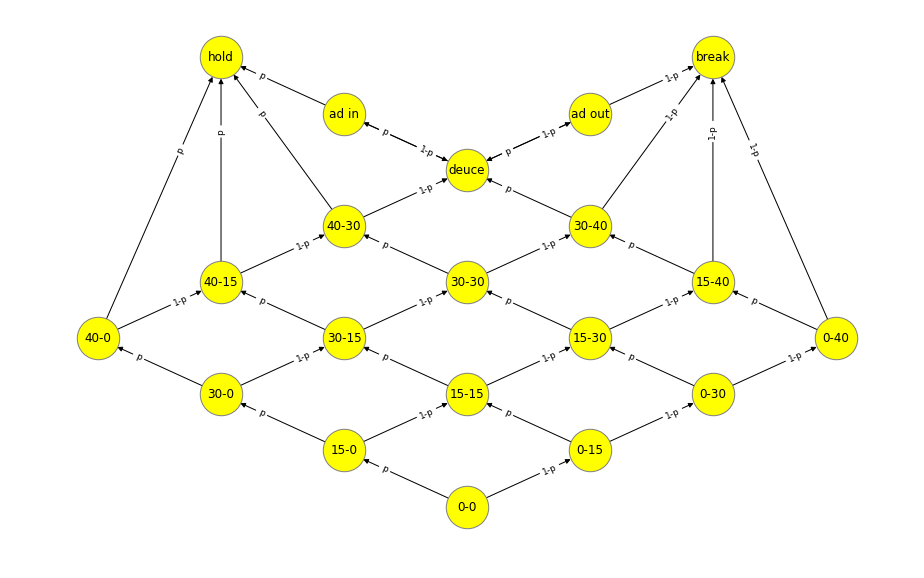

In [10]:
fig, ax = plt.subplots(figsize=(16, 10))
ax = game.draw(ax)
limits = plt.axis('off')
PNGFILE = IMAGES_DIR.joinpath('tennisgamechain.png')
plt.savefig(str(PNGFILE))
plt.show()

You can see the probabilities of winning and losing the point displayed symbolically on each edge of the graph. In future notebooks, we will build up more complicated probabilities of winning and losing each point.

Notice that in this graph framework, we are ignoring paths that cycle between deuce and ads. We will need to take account of that to get correct probability modeling in future notebooks. For now, we are going to focus only on _simple paths_ which don't have cycles.


### Holds and Breaks

Now, let's analyze the number of paths from the start of the game to either a hold or a break.

The Python code can count that up for us very easily.

In [11]:
holds = list(game.point_sequences(end=GameScore.HOLD))
len(holds)

35

In [12]:
Counter([len(path) for path in holds])

Counter({4: 1, 5: 4, 6: 10, 8: 20})

Of the 35 possible paths to hold, only 1 path has 4 points. That's the server holding to love.

In [13]:
[path for path in holds if len(path) == 4]

[[(<GameScore.LOVE_LOVE: '0-0'>, <GameScore.FIFTEEN_LOVE: '15-0'>),
  (<GameScore.FIFTEEN_LOVE: '15-0'>, <GameScore.THIRTY_LOVE: '30-0'>),
  (<GameScore.THIRTY_LOVE: '30-0'>, <GameScore.FORTY_LOVE: '40-0'>),
  (<GameScore.FORTY_LOVE: '40-0'>, <GameScore.HOLD: 'hold'>)]]

There are 4 paths that have the server holding to 15.

In [14]:
[path for path in holds if len(path) == 5]

[[(<GameScore.LOVE_LOVE: '0-0'>, <GameScore.FIFTEEN_LOVE: '15-0'>),
  (<GameScore.FIFTEEN_LOVE: '15-0'>, <GameScore.THIRTY_LOVE: '30-0'>),
  (<GameScore.THIRTY_LOVE: '30-0'>, <GameScore.FORTY_LOVE: '40-0'>),
  (<GameScore.FORTY_LOVE: '40-0'>, <GameScore.FORTY_FIFTEEN: '40-15'>),
  (<GameScore.FORTY_FIFTEEN: '40-15'>, <GameScore.HOLD: 'hold'>)],
 [(<GameScore.LOVE_LOVE: '0-0'>, <GameScore.FIFTEEN_LOVE: '15-0'>),
  (<GameScore.FIFTEEN_LOVE: '15-0'>, <GameScore.THIRTY_LOVE: '30-0'>),
  (<GameScore.THIRTY_LOVE: '30-0'>, <GameScore.THIRTY_FIFTEEN: '30-15'>),
  (<GameScore.THIRTY_FIFTEEN: '30-15'>, <GameScore.FORTY_FIFTEEN: '40-15'>),
  (<GameScore.FORTY_FIFTEEN: '40-15'>, <GameScore.HOLD: 'hold'>)],
 [(<GameScore.LOVE_LOVE: '0-0'>, <GameScore.FIFTEEN_LOVE: '15-0'>),
  (<GameScore.FIFTEEN_LOVE: '15-0'>, <GameScore.FIFTEEN_ALL: '15-15'>),
  (<GameScore.FIFTEEN_ALL: '15-15'>, <GameScore.THIRTY_FIFTEEN: '30-15'>),
  (<GameScore.THIRTY_FIFTEEN: '30-15'>, <GameScore.FORTY_FIFTEEN: '40-15'>),
  (<

We can see that the paths to a break have the same number of possible paths.

In [15]:
breaks = list(game.point_sequences(end=GameScore.BREAK))
len(breaks)

35

In [16]:
Counter([len(path) for path in breaks])

Counter({4: 1, 5: 4, 6: 10, 8: 20})